# Script to Plot Sea Ice Data
**Description:** Uses model and observational sea ice data as input and plots both rectangular and polar stereographic projections.  
**Date:** July 2023   
**Authors:** David Clemens-Sewall, Dave Bailey, Alice DuVivier, Teagan King, Emma Perkins  
**Adpated from:** [CESM Tutorial CICE Diagnostics](https://github.com/NCAR/CESM-Tutorial/blob/main/notebooks/diagnostics/cice/advanced_cice.ipynb)

## **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

## **Install Relevant Packages**

In [ ]:
# Install packages not included in google colab
!pip install cartopy
!pip install pop_tools
!pip install cftime

In [ ]:
# Import relevant packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import numpy as np
import os
import pop_tools
import warnings
import xarray as xr

### **Load Data**

In [ ]:
# Sea Ice data:
root_path = '/content/drive/Shareddrives/NNA-CPAD-Tutorial/Data/CMIP_data/Global_1850_Present/'

var_names_clim = ['sic_rg',
                  'sit_rg'
                 ]

var_names_obs = ['ice_cov',
                 'SST_cpl',
                ]
# set this to True if you want to plot ice_cov_prediddle and SST_cpl_prediddle
use_prediddle = False

# read in model data
da_clim_list = []
for var_name in var_names_clim:
    files = root_path + "clim_sic_cesmLE.nc"
    ds_in = xr.open_mfdataset(files, decode_times=False)
    da_clim_list.append(ds_in[var_name])
    del ds_in
ds_clim = xr.merge(da_clim_list)
del da_clim_list

# read in observational data
da_obs_list = []
for var_name in var_names_obs:
    files = root_path + "sst_sic_obs_cesmLE.nc"
    ds_in = xr.open_mfdataset(files, decode_times=False)
    if use_prediddle == False:
      da_obs_list.append(ds_in[var_name])
    else:
      da_obs_list.append(ds_in[var_name+'_prediddle'])
    del ds_in
ds_obs = xr.merge(da_obs_list)
del da_obs_list

In [ ]:
ds_clim

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1980)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) int64 0 28 59 89 120 150 ... 60072 60102 60133 60163 60194
Data variables:
    sic_rg   (time, lat, lon) float32 dask.array<chunksize=(1980, 180, 360), meta=np.ndarray>
    sit_rg   (time, lat, lon) float32 dask.array<chunksize=(1980, 180, 360), meta=np.ndarray>

In [ ]:
ds_obs

<xarray.Dataset>
Dimensions:            (lon: 360, lat: 180, time: 2076)
Coordinates:
  * lon                (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time               (time) float64 15.5 45.0 74.5 ... 6.31e+04 6.313e+04
Data variables:
    ice_cov_prediddle  (time, lat, lon) float32 dask.array<chunksize=(2076, 180, 360), meta=np.ndarray>
    SST_cpl_prediddle  (time, lat, lon) float32 dask.array<chunksize=(2076, 180, 360), meta=np.ndarray>
Attributes:
    long_name:  Sea-ice concentration before time diddling
    units:      fraction

### Plotting
If you'd like to plot rectangular sea ice data, you can simply call .plot() on a particular time slice.

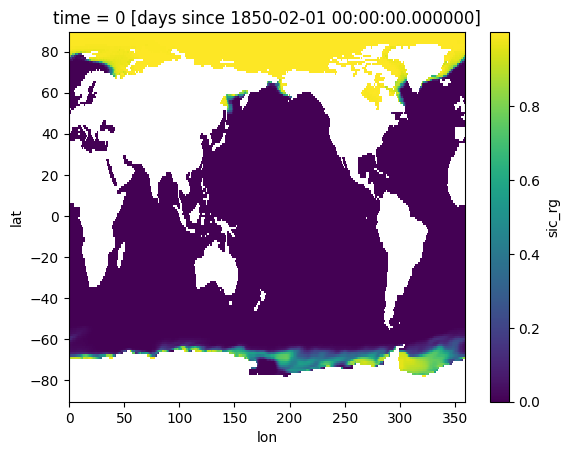

In [ ]:
ds_clim['sic_rg'].isel(time=0).plot()

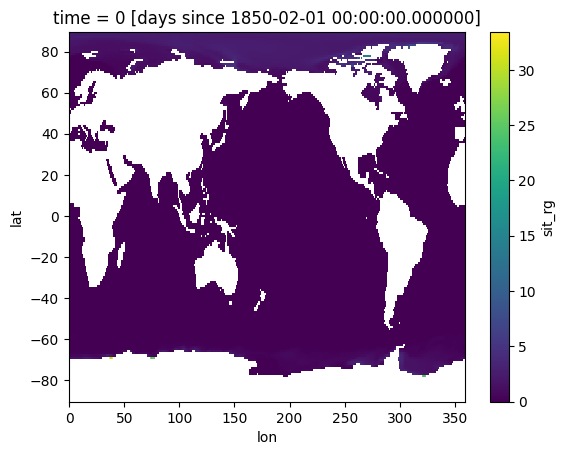

In [ ]:
ds_clim['sit_rg'].isel(time=0).plot()

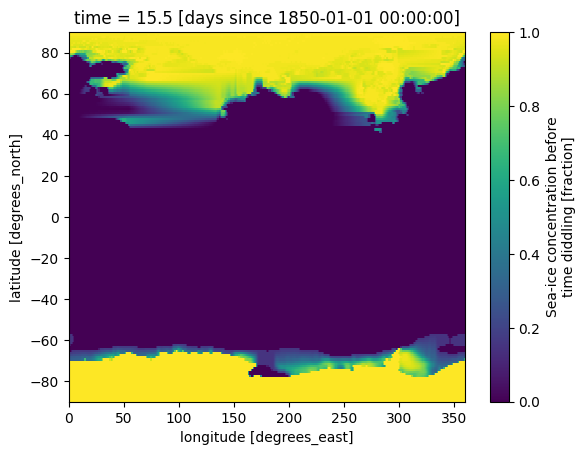

In [ ]:
if use_prediddle == False:
  ds_obs['ice_cov'].isel(time=0).plot()
else:
  ds_obs['ice_cov_prediddle'].isel(time=0).plot()

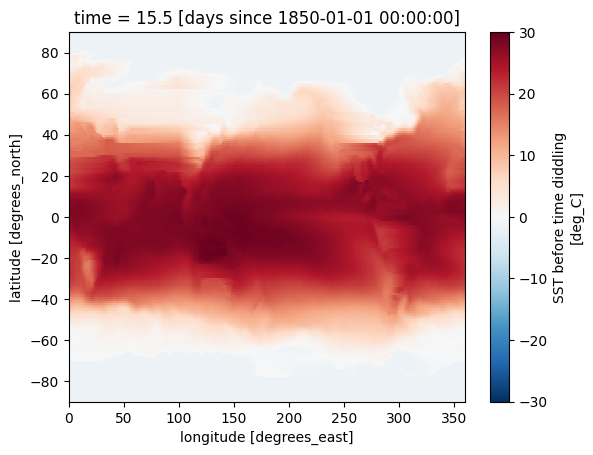

In [ ]:
if use_prediddle == False:
  ds_obs['SST_cpl'].isel(time=0).plot()
else:
    ds_obs['SST_cpl_prediddle'].isel(time=0).plot()

### Polar Stereographic Plots
To make polar stereographic plots, which are much more useful for our sea ice data, we create a circular boundary, specify the North Polar Stereo projection, and loop through each variable for model and observational data in order to generate plots.

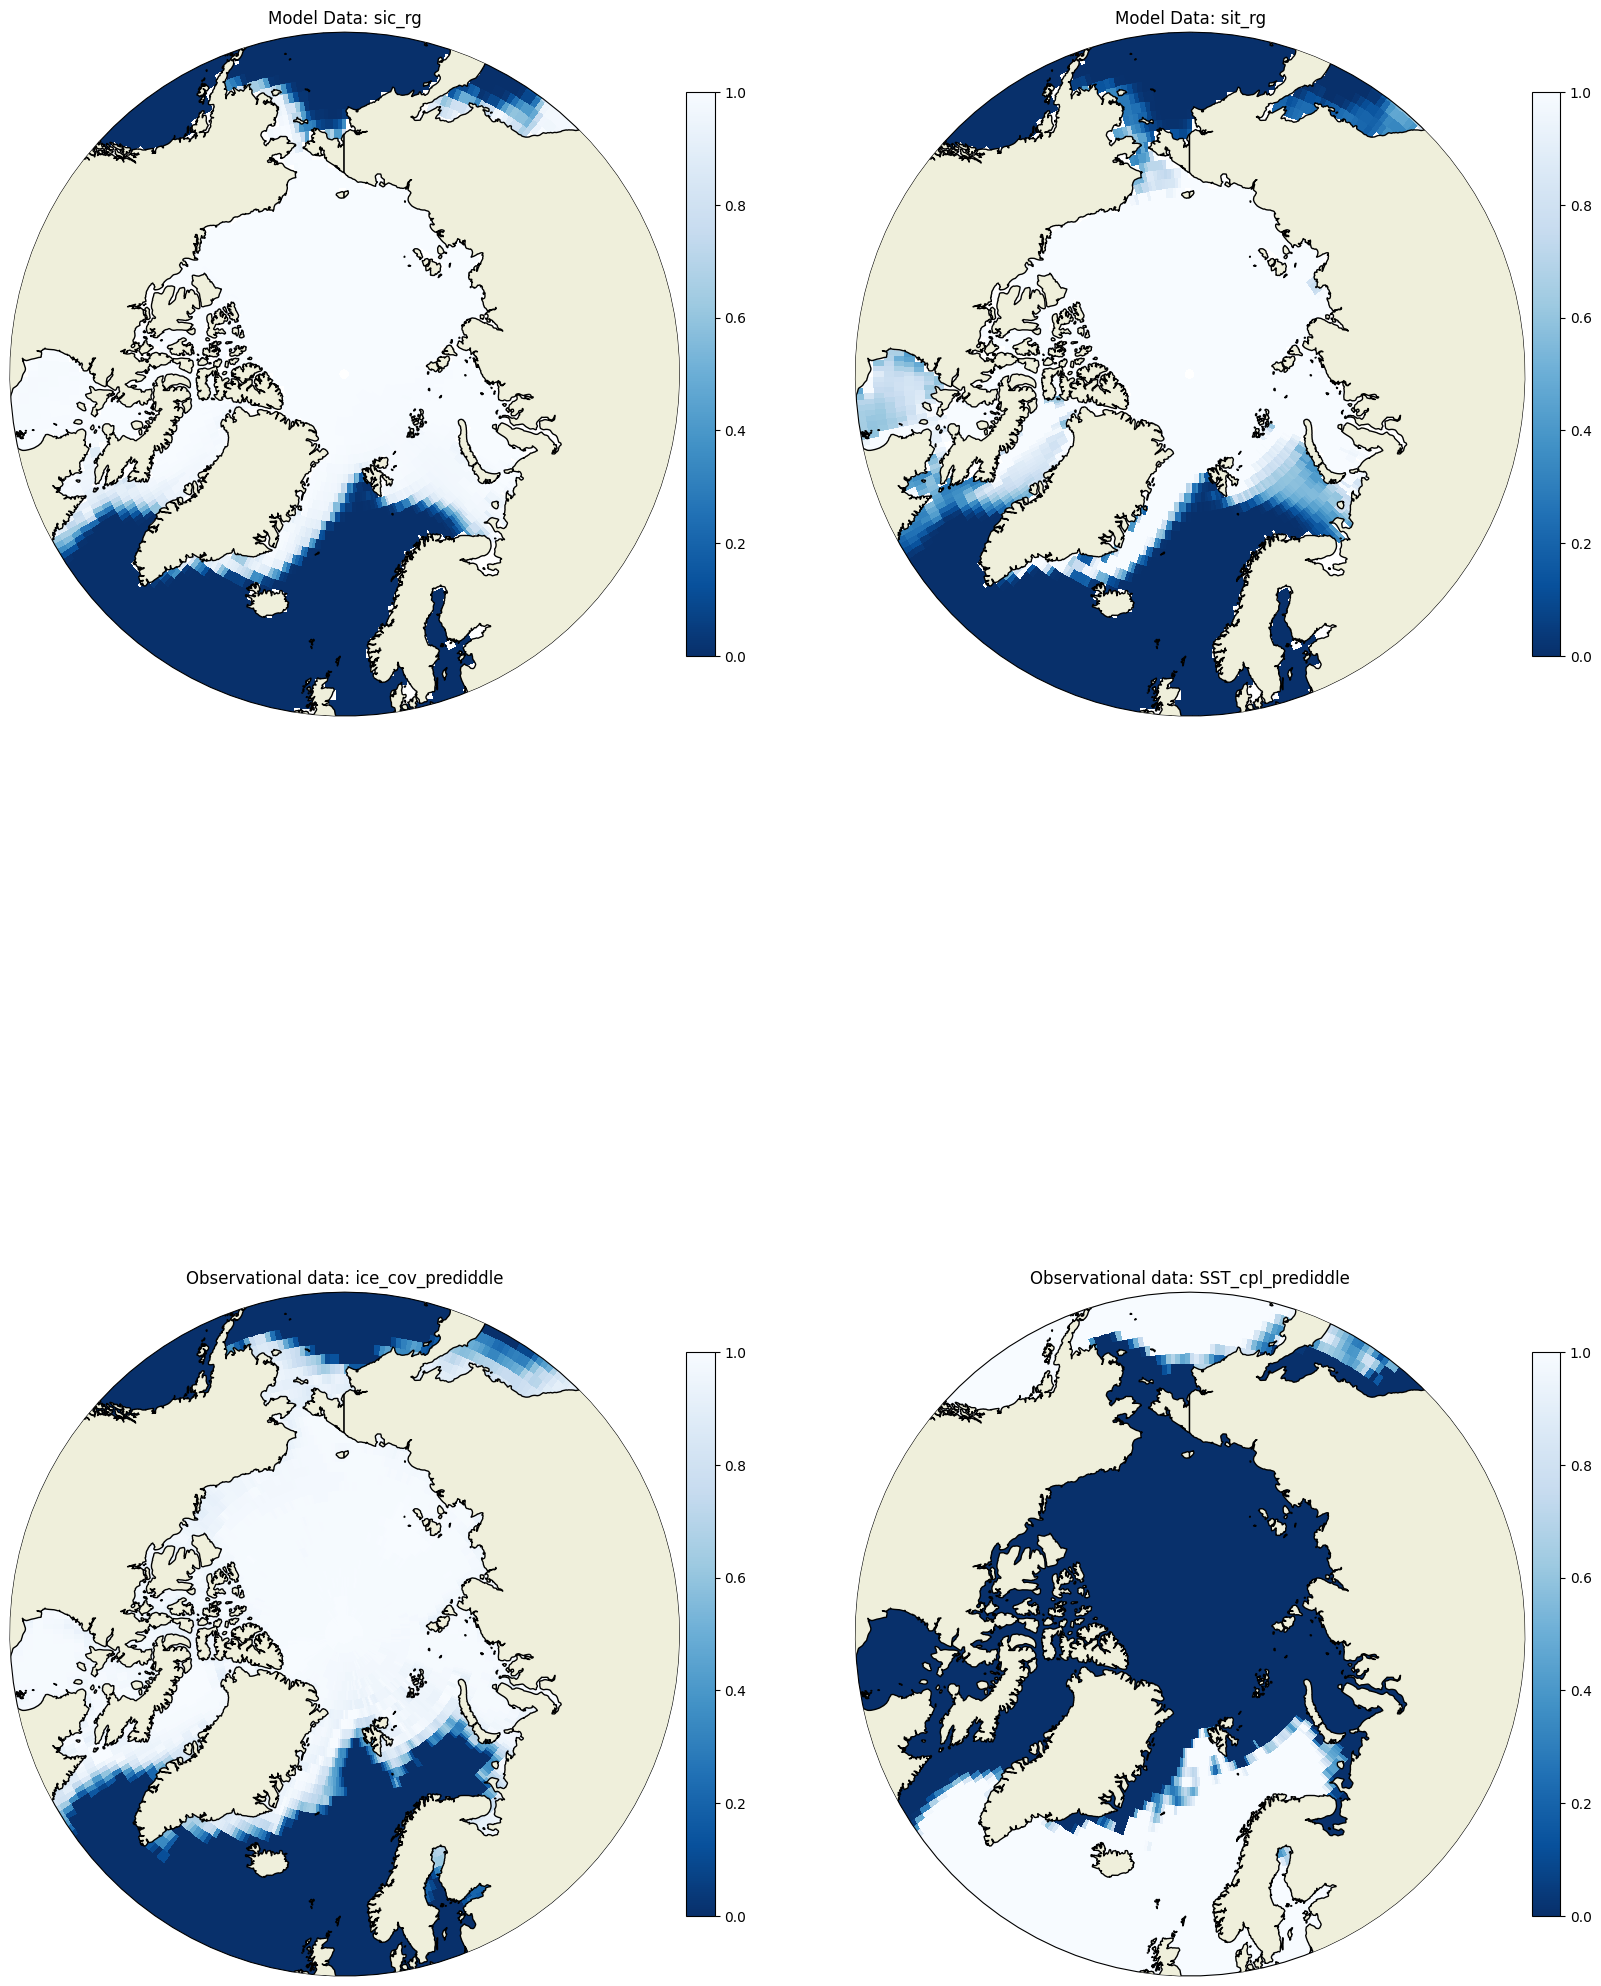

In [ ]:
# Make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Set color map
matplotlib.colormaps['Blues_r']

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20,30),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

# This creates a subplot for each clim var
for var in range(len(var_names_clim)):
    ax = axs[var]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds_clim['lon'],
                       ds_clim['lat'],
                       ds_clim[var_names_clim[var]].sel({'time': 0}).squeeze(),
                       cmap=cmap,vmax=1,vmin=0,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title("Model Data: " + str(var_names_clim[var]))

# This creates a subplot for each obs var
for var in range(len(var_names_obs)):
    ax = axs[var + len(var_names_clim)] # set to next subplot to not overwrite clim var plots
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    if use_prediddle == False:
      this=ax.pcolormesh(ds_obs['lon'],
                        ds_obs['lat'],
                        ds_obs[var_names_obs[var]].sel({'time': 15.5}).squeeze(),
                        cmap=cmap,vmax=1,vmin=0,
                        transform=ccrs.PlateCarree())
    else:
      this=ax.pcolormesh(ds_obs['lon'],
                        ds_obs['lat'],
                        ds_obs[var_names_obs[var]+'_prediddle'].sel({'time': 15.5}).squeeze(),
                        cmap=cmap,vmax=1,vmin=0,
                        transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    if use_prediddle == False:
      ax.set_title("Observational data: " + str(var_names_obs[var]))
    else:
      ax.set_title("Observational data: " + str(var_names_obs[var]+'_prediddle'))